# NOTEBOOK 2: Data Exploration

## Imports libraries for data exploration

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as snow_funcs
import snowflake.snowpark.types as snow_types

from config import snowflake_conn_prop

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


%matplotlib inline

C:\Users\Makkuva Komal\AppData\Roaming\Python\Python310\site-packages\snowflake\connector\options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (19.0.1), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(
Matplotlib is building the font cache; this may take a moment.


## Create Snowpark Session

In [2]:
session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='MEDIUM', CURRENT_DATABASE()='LLM', CURRENT_SCHEMA()='PUBLIC')]


## Pandas DataFrames compared to Snowpark DataFrames

This section showcase the differences between using a Pandas Dataframe (data in memory on client machine) and a Snowpark DataFrame (data in Snowflake)

In [3]:
# Creating a Pandas DataFrame
pandas_df = pd.read_csv('datasets/housing/housing.csv')
print(type(pandas_df))

<class 'pandas.core.frame.DataFrame'>


In [4]:
# Creating a Snowpark DataFrame
snowpark_df = session.table('HOUSING_DATA')
print(type(snowpark_df))

<class 'snowflake.snowpark.table.Table'>


Since a Snowpark DataFrame does not contain any dayta, ie only a "pointer" to data in Snowflake, the memory used by it on the client side is minimum.

In [5]:
# Compare size
print('Size in MB of Pandas DataFrame in Memory:\n', np.round(sys.getsizeof(pandas_df) / (1024.0**2), 2))
print('Size in MB of Snowpark DataFrame in Memory:\n', np.round(sys.getsizeof(snowpark_df) / (1024.0**2), 2))

Size in MB of Pandas DataFrame in Memory:
 2.7
Size in MB of Snowpark DataFrame in Memory:
 0.0


A Snowpark DataFrame can be easily converted to a Pandas DataFrame by using the **to_pandas** method, this will cause the data to be pulled back from Snowflake and loaded into the client memory

In [6]:
# Converting a Snowpark DataFrame to Pandas DataFrame
pandas_df_from_snowflake = snowpark_df.to_pandas()

In [7]:
pandas_df.shape, pandas_df_from_snowflake.shape

((20640, 10), (20640, 10))

To have a peak of the data that a Snowpark DataFrame is representing **show** function can be used

In [8]:
snowpark_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LONGITUDE"  |"LATITUDE"  |"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"POPULATION"  |"HOUSEHOLDS"  |"MEDIAN_INCOME"  |"MEDIAN_HOUSE_VALUE"  |"OCEAN_PROXIMITY"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|-122.23      |37.88       |41.0                  |880.0          |129.0             |322.0         |126.0         |8.3252           |452600.0              |NEAR BAY           |
|-122.22      |37.86       |21.0                  |7099.0         |1106.0            |2401.0        |1138.0        |8.3014           |358500.0              |NEAR BAY           |
|-122.24      |37.85       |52.0                  |1467.0         |190.0             |496.0         |177.0    

Looking at the queries will show us what is actual keept in the client memmory, the SQL needed to return the data accordingly to our DataFram defenition.

In [9]:
list(snowpark_df.queries['queries'])

['SELECT  *  FROM HOUSING_DATA']

The Snowpark DataFrame API supports multiple ways to select specific columns

In [10]:
# Select specific columns
snowpark_df_subset = snowpark_df.select('HOUSING_MEDIAN_AGE','TOTAL_ROOMS','TOTAL_BEDROOMS','HOUSEHOLDS','OCEAN_PROXIMITY')
snowpark_df_subset.show()

----------------------------------------------------------------------------------------------
|"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"HOUSEHOLDS"  |"OCEAN_PROXIMITY"  |
----------------------------------------------------------------------------------------------
|41.0                  |880.0          |129.0             |126.0         |NEAR BAY           |
|21.0                  |7099.0         |1106.0            |1138.0        |NEAR BAY           |
|52.0                  |1467.0         |190.0             |177.0         |NEAR BAY           |
|52.0                  |1274.0         |235.0             |219.0         |NEAR BAY           |
|52.0                  |1627.0         |280.0             |259.0         |NEAR BAY           |
|52.0                  |919.0          |213.0             |193.0         |NEAR BAY           |
|52.0                  |2535.0         |489.0             |514.0         |NEAR BAY           |
|52.0                  |3104.0         |687.0     

In [11]:
# pandas-like syntax for column selection from Snowflake dataframe
snowpark_df_subset = snowpark_df[['HOUSING_MEDIAN_AGE','TOTAL_ROOMS','TOTAL_BEDROOMS','HOUSEHOLDS','OCEAN_PROXIMITY']]
snowpark_df_subset.show()

----------------------------------------------------------------------------------------------
|"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"HOUSEHOLDS"  |"OCEAN_PROXIMITY"  |
----------------------------------------------------------------------------------------------
|41.0                  |880.0          |129.0             |126.0         |NEAR BAY           |
|21.0                  |7099.0         |1106.0            |1138.0        |NEAR BAY           |
|52.0                  |1467.0         |190.0             |177.0         |NEAR BAY           |
|52.0                  |1274.0         |235.0             |219.0         |NEAR BAY           |
|52.0                  |1627.0         |280.0             |259.0         |NEAR BAY           |
|52.0                  |919.0          |213.0             |193.0         |NEAR BAY           |
|52.0                  |2535.0         |489.0             |514.0         |NEAR BAY           |
|52.0                  |3104.0         |687.0     

In [12]:
list(snowpark_df_subset.queries['queries'])

['SELECT "HOUSING_MEDIAN_AGE", "TOTAL_ROOMS", "TOTAL_BEDROOMS", "HOUSEHOLDS", "OCEAN_PROXIMITY" FROM HOUSING_DATA']

**with_column** function can be used to add a new column to a Snowpark DataFrame (with_columns allows us to add multiple at the same time)

In [13]:
snowpark_df_new_col = snowpark_df_subset.with_column('BEDROOM_RATIO', snow_funcs.col('TOTAL_BEDROOMS') / snow_funcs.col('TOTAL_ROOMS'))
snowpark_df_new_col.show()

--------------------------------------------------------------------------------------------------------------------
|"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"HOUSEHOLDS"  |"OCEAN_PROXIMITY"  |"BEDROOM_RATIO"      |
--------------------------------------------------------------------------------------------------------------------
|41.0                  |880.0          |129.0             |126.0         |NEAR BAY           |0.14659090909090908  |
|21.0                  |7099.0         |1106.0            |1138.0        |NEAR BAY           |0.15579659106916466  |
|52.0                  |1467.0         |190.0             |177.0         |NEAR BAY           |0.12951601908657123  |
|52.0                  |1274.0         |235.0             |219.0         |NEAR BAY           |0.18445839874411302  |
|52.0                  |1627.0         |280.0             |259.0         |NEAR BAY           |0.1720958819913952   |
|52.0                  |919.0          |213.0             |193.0

In [14]:
snowpark_df_new_col.queries['queries']

['SELECT "HOUSING_MEDIAN_AGE", "TOTAL_ROOMS", "TOTAL_BEDROOMS", "HOUSEHOLDS", "OCEAN_PROXIMITY", ("TOTAL_BEDROOMS" / "TOTAL_ROOMS") AS "BEDROOM_RATIO" FROM HOUSING_DATA']

To remove a column from a Snowpark DataFrame **drop** function can be used

In [15]:
snowpark_df_drop_col = snowpark_df_new_col.drop('BEDROOM_RATIO')
snowpark_df_drop_col.show()

----------------------------------------------------------------------------------------------
|"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"HOUSEHOLDS"  |"OCEAN_PROXIMITY"  |
----------------------------------------------------------------------------------------------
|41.0                  |880.0          |129.0             |126.0         |NEAR BAY           |
|21.0                  |7099.0         |1106.0            |1138.0        |NEAR BAY           |
|52.0                  |1467.0         |190.0             |177.0         |NEAR BAY           |
|52.0                  |1274.0         |235.0             |219.0         |NEAR BAY           |
|52.0                  |1627.0         |280.0             |259.0         |NEAR BAY           |
|52.0                  |919.0          |213.0             |193.0         |NEAR BAY           |
|52.0                  |2535.0         |489.0             |514.0         |NEAR BAY           |
|52.0                  |3104.0         |687.0     

To filter (select rows) from a Snowpark DataFrame **filter** or **where** can be used

In [16]:
snowpark_df_filtered = snowpark_df_drop_col.filter(snow_funcs.col('OCEAN_PROXIMITY').in_(['INLAND','ISLAND', 'NEAR BAY']))
snowpark_df_filtered.show()

----------------------------------------------------------------------------------------------
|"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"  |"TOTAL_BEDROOMS"  |"HOUSEHOLDS"  |"OCEAN_PROXIMITY"  |
----------------------------------------------------------------------------------------------
|41.0                  |880.0          |129.0             |126.0         |NEAR BAY           |
|21.0                  |7099.0         |1106.0            |1138.0        |NEAR BAY           |
|52.0                  |1467.0         |190.0             |177.0         |NEAR BAY           |
|52.0                  |1274.0         |235.0             |219.0         |NEAR BAY           |
|52.0                  |1627.0         |280.0             |259.0         |NEAR BAY           |
|52.0                  |919.0          |213.0             |193.0         |NEAR BAY           |
|52.0                  |2535.0         |489.0             |514.0         |NEAR BAY           |
|52.0                  |3104.0         |687.0     

In [17]:
snowpark_df_filtered.queries['queries']

['SELECT "HOUSING_MEDIAN_AGE", "TOTAL_ROOMS", "TOTAL_BEDROOMS", "HOUSEHOLDS", "OCEAN_PROXIMITY" FROM HOUSING_DATA WHERE "OCEAN_PROXIMITY" IN (\'INLAND\', \'ISLAND\', \'NEAR BAY\')']

To to aggregation of the data in a Snowpark DataFrame **group_by** and **agg** can used

In [18]:
# Aggregate data
snowpark_df_agg = snowpark_df_filtered.group_by(['OCEAN_PROXIMITY']).agg([snow_funcs.avg('HOUSEHOLDS').as_('AVG_HOUSEHOLDS')])
snowpark_df_agg.show()

------------------------------------------
|"OCEAN_PROXIMITY"  |"AVG_HOUSEHOLDS"    |
------------------------------------------
|NEAR BAY           |488.6161572052402   |
|INLAND             |477.44756525721266  |
|ISLAND             |276.6               |
------------------------------------------



The returned result for a Snowpark DataFrame can be sorted using **sort**

In [19]:
snowpark_df_sorted = snowpark_df_agg.sort(snow_funcs.col('AVG_HOUSEHOLDS').asc())
snowpark_df_sorted.show()

------------------------------------------
|"OCEAN_PROXIMITY"  |"AVG_HOUSEHOLDS"    |
------------------------------------------
|ISLAND             |276.6               |
|INLAND             |477.44756525721266  |
|NEAR BAY           |488.6161572052402   |
------------------------------------------



## Data Preprocessing using Scikit

Let's start by getting some basic understanding of our data.

We can use the **describe** function on our **numeric** and **character** columns to get some basic statistics, count shows number of non null rows

In [20]:
snowpark_df.describe().show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"LONGITUDE"          |"LATITUDE"          |"HOUSING_MEDIAN_AGE"  |"TOTAL_ROOMS"       |"TOTAL_BEDROOMS"   |"POPULATION"        |"HOUSEHOLDS"       |"MEDIAN_INCOME"     |"MEDIAN_HOUSE_VALUE"  |"OCEAN_PROXIMITY"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |20640.0              |20640.0             |20640.0               |20640.0             |20433.0            |20640.0             |20640.0            |20640.0             |20640.0               |20640              |
|mean       |-119.56970445736435  |35.63186143410853   |28.639486434108527    |2635.763081395348

Above shows that TOTAL_BEDROOMS has missing values ie the count is less than 20640, so we need to manage that before training a model.

Using the schema of a Snowpark DataFrame allows us to easily get the numerical and categorical (character) column names

In [21]:
# Get all numerical columns
numeric_types = [snow_types.DecimalType, snow_types.LongType, snow_types.DoubleType, snow_types.FloatType, snow_types.IntegerType]
numeric_columns = [c.name for c in snowpark_df.schema.fields if type(c.datatype) in numeric_types]
numeric_columns

['LONGITUDE',
 'LATITUDE',
 'HOUSING_MEDIAN_AGE',
 'TOTAL_ROOMS',
 'TOTAL_BEDROOMS',
 'POPULATION',
 'HOUSEHOLDS',
 'MEDIAN_INCOME',
 'MEDIAN_HOUSE_VALUE']

In [22]:
# Get all categorical columns (columns with character data type)
categorical_types = [snow_types.StringType]
categorical_columns = [c.name for c in snowpark_df.schema.fields if type(c.datatype) in categorical_types]
categorical_columns

['OCEAN_PROXIMITY']

Now we will impute missing values from total_bedroom using scikit learn impute function

In [23]:
from sklearn.impute import SimpleImputer

# Pull back the data from SNowflake into a Pandas Dataframe, data now is stored in memory
pandas_df = snowpark_df.to_pandas()

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(pandas_df[['TOTAL_BEDROOMS']])
pandas_df['TOTAL_BEDROOMS'] = imputer.transform(pandas_df[['TOTAL_BEDROOMS']])
pandas_df

,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Now if we print count of total_bedrooms column we will see full count of 20640.

In [24]:
print(pandas_df["TOTAL_BEDROOMS"].count())

20640


Similarly machine learning models expects data to be normalised before training the models.

For that we can use scikit learn normalise functions to normalise the data

In [25]:
from sklearn import preprocessing

df_norm = preprocessing.normalize(pandas_df[["LATITUDE","LONGITUDE","TOTAL_BEDROOMS"]].dropna())
df_norm


array([[ 0.20847179, -0.67269026,  0.70994882],
       [ 0.03400467, -0.10977419,  0.99337471],
       [ 0.16522991, -0.53362495,  0.82942359],
       ...,
       [ 0.07862854, -0.24172843,  0.967153  ],
       [ 0.0920332 , -0.2831719 ,  0.95464316],
       [ 0.06258634, -0.19273478,  0.97925291]])

What we did so far with scikit learn functions was using pandas dataframe which was all executed on local machine, but in next worksheet we will see how we can run all this inside Snowflake.

## Data Visualisation

To understand which features are useful for our machine learning models we can do some visualisation on our data set to get better view of our data. 
Let's create a basic visualisation on data we have

<Axes: ylabel='MEDIAN_HOUSE_VALUE'>

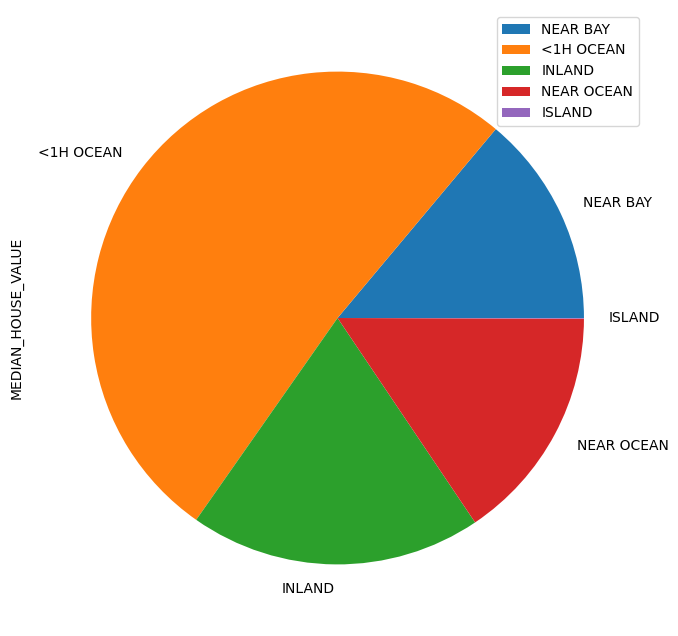

In [26]:
# We will start by creating a pie chart. To create pie chart we will OCEAN_PROXIMITY column and see its distribution.
# First we get the distinct values in column OCEAN_PROXIMITY and the number of rows for each unique value
# We are are using pyplot for this visualisation

df_pie = snowpark_df.group_by("OCEAN_PROXIMITY").agg(snow_funcs.sum('MEDIAN_HOUSE_VALUE').as_('MEDIAN_HOUSE_VALUE')).to_pandas()
df_pie.set_index('OCEAN_PROXIMITY', inplace=True)
df_pie.plot.pie(y='MEDIAN_HOUSE_VALUE', figsize=(8,8))
#plt.show()

To analyse distribution of our continous variables we will plot histograms for all continuous variables

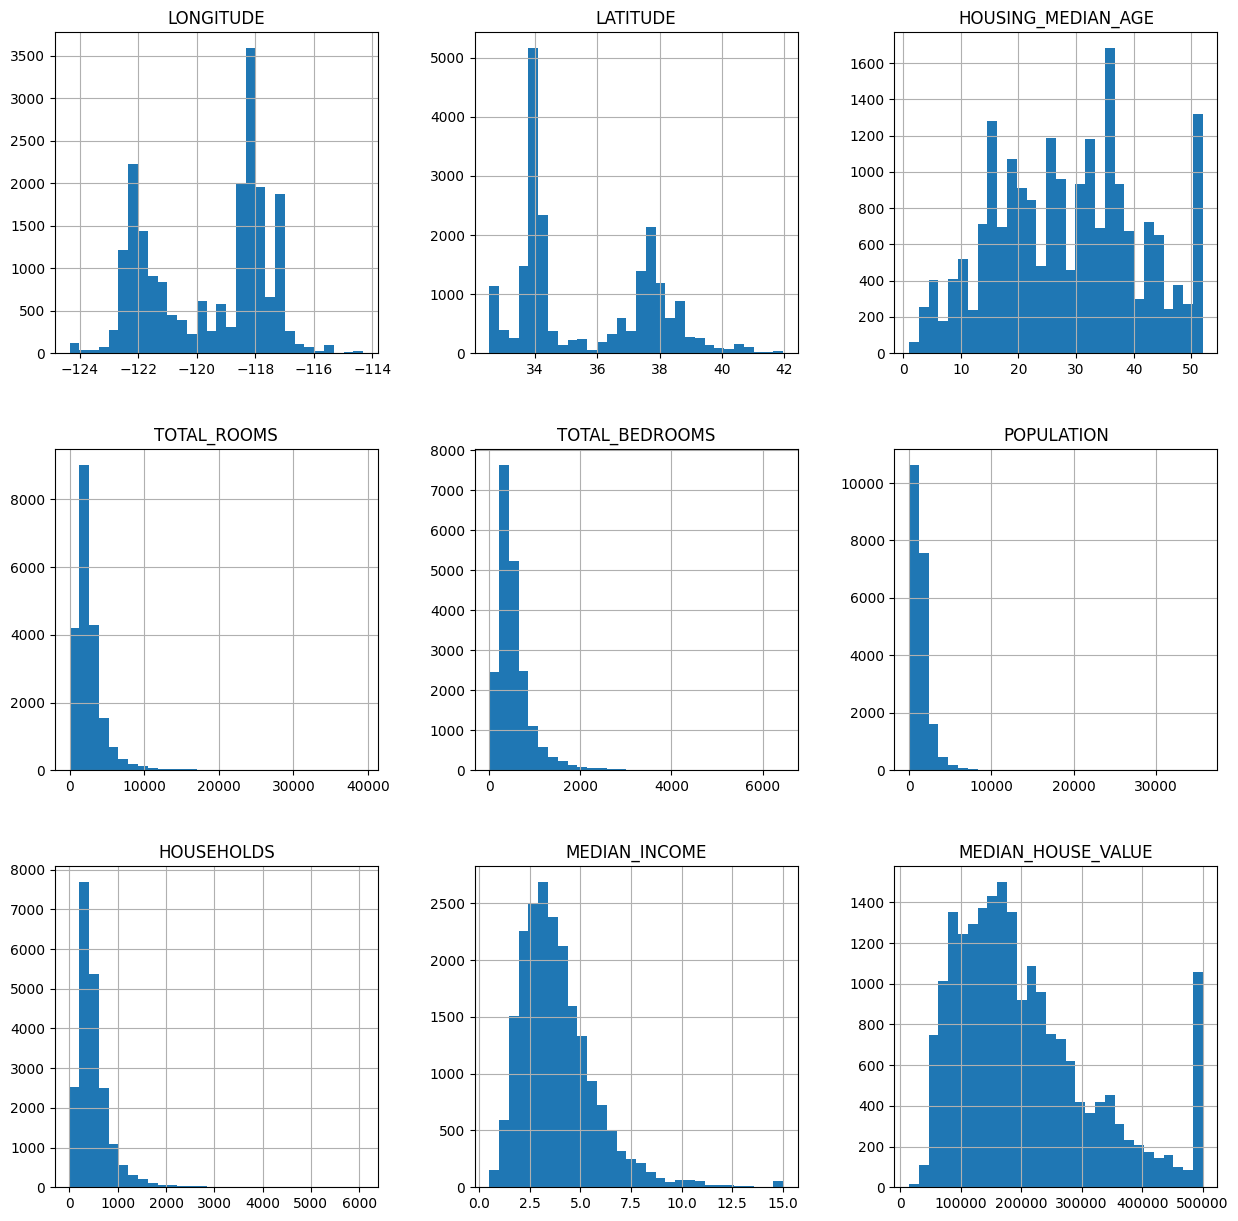

In [27]:
# Plotting histograms for all continous variables

pd_numeric = snowpark_df.select(numeric_columns).to_pandas()
pd_numeric.hist(bins=30, figsize=(15,15))
plt.show()

Plotting correlation matrix helps to identify how different features are related to each others

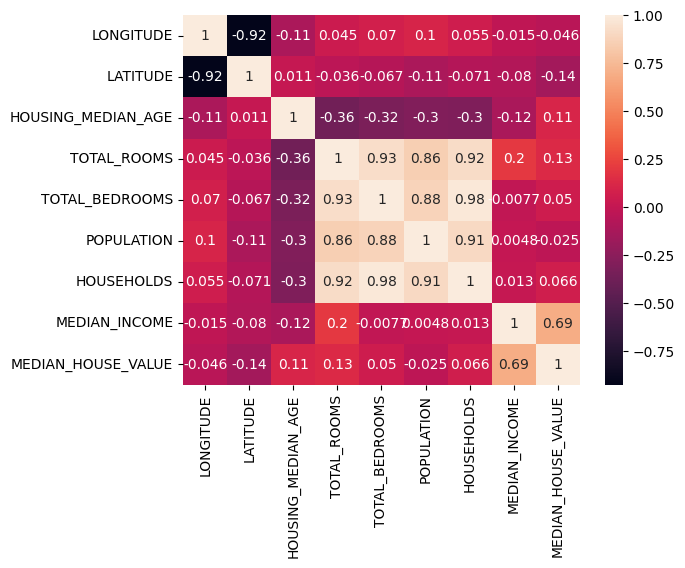

In [28]:
# We will use seaborn lib to plot correlation matrix
sn.heatmap(snowpark_df[numeric_columns].to_pandas().corr(), annot=True)
plt.show()

In [29]:
session.close()